In [26]:
# from google.colab import drive
# drive.mount("/content/drive")

In [27]:
import pandas as pd
import numpy as np
import itertools
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [28]:
dataset = pd.read_csv('/content/synthetic_advertising.csv')
# or try 'cp1252' if 'latin-1' doesn't work
dataset.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,52.472407,64,56378,96.056210,Flash Deal,Chicago,1,Germany,2024-01-01 00:00:00,0
1,87.042858,29,24255,273.497428,Sale Discount,Los Angeles,0,Canada,2024-01-01 01:00:00,0
2,73.919637,33,34484,213.573138,Flash Deal,Chicago,1,UK,2024-01-01 02:00:00,1
3,65.919509,41,145703,88.026071,Limited Offer,Chicago,1,Germany,2024-01-01 03:00:00,0
4,39.361118,36,76549,160.080855,Sale Discount,Houston,0,UK,2024-01-01 04:00:00,0


In [29]:
def entropy(y):
  if isinstance(y, pd.Series):
    a = y.value_counts()/y.shape[0]
    entropy = np.sum(-a*np.log2(a+1e-9))
    return(entropy)
  else:
    raise('Object must be a Pandas Series.')

entropy(dataset.Male)

0.9990649286922206

In [30]:
def gini(y):
    if isinstance(y, pd.Series):
        a = y.value_counts() / y.shape[0]
        gini = 1 - np.sum(a**2)
        return gini
    else:
        raise ValueError("Object must be a Pandas Series.")


In [31]:
def variance(y):
  if(len(y) == 1):
    return 0
  else:
    return y.var()

def information_gain(y, mask, func=entropy):
  a = sum(mask)
  b = mask.shape[0] - a

  if(a == 0 or b ==0):
    gain = 0
  else:
    if y.dtypes != 'O':
      gain = variance(y) - (a/(a+b)* variance(y[mask])) - (b/(a+b)*variance(y[-mask]))
    else:
      gain = func(y)-a/(a+b)*func(y[mask])-b/(a+b)*func(y[-mask])

  return gain

In [32]:
information_gain(dataset['Clicked on Ad'], dataset['Male'] == 1)

0.0002055738225993642

To calculate the best split of a numeric variable, first, all possible values that the variable is taking must be obtained. Once we have the options, for each option we will calculate the Information Gain using as a filter if the value is less than that value. Obviously, the first possible data will be drop, because the split will include all values.

In case we have categorical variables, the idea is the same, only that in this case we will have to calculate the Information Gain for all possible combinations of that variable, excluding the option that includes all the options (since it would not be doing any split). This is quite computationally costly if we have a high number of categories, that decision tree algorithms usually only accept categorical variables with less than 20 categories.

So, once we have all the splits, we will stick with the split that generates the highest Information Gain.

In [33]:
def categorical_options(a, max_categories=5):
    a = a.unique()

    if len(a) > max_categories:
        a = np.random.choice(a, max_categories, replace=False)  # Sample categories

    opciones = []
    for L in range(1, len(a)):
        opciones.extend(itertools.combinations(a, L))

    return [list(subset) for subset in opciones]


def max_information_gain_split(x, y, func=entropy):

  split_value = []
  gain = []

  numeric_variable = True if x.dtypes != 'O' else False

  if numeric_variable:
    options = x.sort_values().unique()[1:]
  else:
    options = categorical_options(x)

  # Calculate gain for all values
  for val in options:
    mask =   x < val if numeric_variable else x.isin(val)
    val_gain = information_gain(y, mask, func)
    # Append results
    gain.append(val_gain)
    split_value.append(val)

  if len(gain) == 0:
    return(None,None,None,False)

  else:
    best_gain = max(gain)
    best_gain_index = gain.index(best_gain)
    best_split = split_value[best_gain_index]
    return(best_gain,best_split,numeric_variable, True)

age_gain, age_split, _, _ = max_information_gain_split(dataset['Age'], dataset['Clicked on Ad'],)

print(
  "The best split for Age is when the variable is less than ",
  age_split,"\nInformation Gain for that split is:", age_gain)

The best split for Age is when the variable is less than  27 
Information Gain for that split is: 0.0008711082512955493


best split will be the one that generates the highest Information Gain. To know which one is it, we simply have to calculate the Information Gain for each of the predictor variables of the model.

In [34]:
dataset.drop('Clicked on Ad', axis= 1).apply(max_information_gain_split, y = dataset['Clicked on Ad'])

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp
0,0.001564,0.000871,0.000519,0.001045,0.000008,0.001424,0.000206,0.0001,0.00078
1,30.65975,27,20207,216.98,"[Flash Deal, New Launch]","[Chicago, Houston, New York]",1,"[Germany, France]","[2024-02-06 02:00:00, 2024-02-10 16:00:00, 202..."
2,True,True,True,True,False,False,True,False,False
3,True,True,True,True,True,True,True,True,True


For Training

In [35]:
def get_best_split(y, dataset):
  masks = dataset.drop(y, axis= 1).apply(max_information_gain_split, y = dataset[y])
  if sum(masks.loc[3,:]) == 0:
    return(None, None, None, None)

  else:
    # Get only masks that can be splitted
    masks = masks.loc[:,masks.loc[3,:]]

    # Get the results for split with highest IG
    split_variable = masks.iloc[0].astype(np.float32).idxmax()
    #split_valid = masks[split_variable][]
    split_value = masks[split_variable][1]
    split_gain = masks[split_variable][0]
    split_numeric = masks[split_variable][2]

    return(split_variable, split_value, split_gain, split_numeric)


def make_split(variable, value, dataset, is_numeric):
  if is_numeric:
    dataset_1 = dataset[dataset[variable] < value]
    dataset_2 = dataset[(dataset[variable] < value) == False]
  else:
    dataset_1 = dataset[dataset[variable].isin(value)]
    dataset_2 = dataset[(dataset[variable].isin(value)) == False]

  return(dataset_1,dataset_2)


def make_prediction(dataset, target_factor):
  if target_factor:
    pred = dataset.value_counts().idxmax()
  else:
    pred = dataset.mean()

  return pred

In [36]:
def train_tree(dataset,y, target_factor, max_depth = None,min_samples_split = None, min_information_gain = 1e-20, counter=0, max_categories = 20):

  if counter==0:
    types = dataset.dtypes
    check_columns = types[types == "object"].index
    for column in check_columns:
      var_length = len(dataset[column].value_counts())
      # if var_length > max_categories:
      #   raise ValueError('The variable ' + column + ' has '+ str(var_length) + ' unique values, which is more than the accepted ones: ' +  str(max_categories))

  if max_depth == None:
    depth_cond = True

  else:
    if counter < max_depth:
      depth_cond = True

    else:
      depth_cond = False

  if min_samples_split == None:
    sample_cond = True

  else:
    if dataset.shape[0] > min_samples_split:
      sample_cond = True

    else:
      sample_cond = False

  if depth_cond & sample_cond:
    var,val,gain,var_type = get_best_split(y, dataset)

    if gain is not None and gain >= min_information_gain:
      counter += 1
      left,right = make_split(var, val, dataset,var_type)

      # Instantiate sub-tree
      split_type = "<=" if var_type else "in"
      question =   "{} {}  {}".format(var,split_type,val)
      # question = "\n" + counter*" " + "|->" + var + " " + split_type + " " + str(val)
      subtree = {question: []}

      # Find answers (recursion)
      yes_answer = train_tree(left,y, target_factor, max_depth,min_samples_split,min_information_gain, counter)

      no_answer = train_tree(right,y, target_factor, max_depth,min_samples_split,min_information_gain, counter)

      if yes_answer == no_answer:
        subtree = yes_answer

      else:
        subtree[question].append(yes_answer)
        subtree[question].append(no_answer)

    else:
      pred = make_prediction(dataset[y],target_factor)
      return pred

  else:
    pred = make_prediction(dataset[y],target_factor)
    return pred

  return subtree

max_depth = 5
min_samples_split = 20
min_information_gain  = 1e-5

decision = train_tree(dataset,'Clicked on Ad',True, max_depth,min_samples_split,min_information_gain)

decision

{'Daily Time Spent on Site <=  30.6597497195088': [0,
  {"City in  ['San Francisco']": [{"Ad Topic Line in  ['Limited Offer', 'Sale Discount']": [{'Daily Internet Usage <=  75.1593696308833': [0,
        {"Timestamp in  ['2024-02-02 11:00:00', '2024-02-08 05:00:00', '2024-01-15 06:00:00', '2024-01-09 03:00:00']": [0,
          1]}]},
      {"Timestamp in  ['2024-01-10 00:00:00', '2024-01-13 15:00:00', '2024-01-17 09:00:00', '2024-01-30 20:00:00']": [0,
        {'Daily Time Spent on Site <=  39.1523425748557': [0, 1]}]}]},
    {'Daily Time Spent on Site <=  81.1805673280416': [{'Daily Time Spent on Site <=  80.6925186581673': [{"Timestamp in  ['2024-01-09 22:00:00', '2024-01-28 07:00:00', '2024-02-02 15:00:00', '2024-01-23 21:00:00']": [0,
          1]},
        1]},
      {"Country in  ['UK', 'France']": [{'Area Income <=  79664': [1, 0]},
        0]}]}]}]}

In [37]:
def classify_data(observation, tree):
  question = list(tree.keys())[0]

  if question.split()[1] == '<=':
    if observation[question.split()[0]] <= float(question.split()[2]):
      answer = tree[question][0]
    else:
      answer = tree[question][1]
  else:
    if observation[question.split()[0]] in (question.split()[2]):
      answer = tree[question][0]
    else:
      answer = tree[question][1]

  if not isinstance(answer, dict):
    return answer
  else:
    residual_tree = answer
    return classify_data(observation, answer)

In [38]:
# Load dataset (replace with your own)
X = dataset.drop("Clicked on Ad", axis=1)
y = dataset["Clicked on Ad"]

# Perform one-hot encoding on categorical features
X = pd.get_dummies(X)  # This will convert categorical columns to numerical

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train decision tree with entropy
clf_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=5)
clf_entropy.fit(X_train, y_train)
y_pred_entropy = clf_entropy.predict(X_test)

# Train decision tree with Gini index
clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=5)
clf_gini.fit(X_train, y_train)
y_pred_gini = clf_gini.predict(X_test)

# Compare performance
print("Accuracy using Entropy:", accuracy_score(y_test, y_pred_entropy))
print("Accuracy using Gini Index:", accuracy_score(y_test, y_pred_gini))

Accuracy using Entropy: 0.465
Accuracy using Gini Index: 0.535


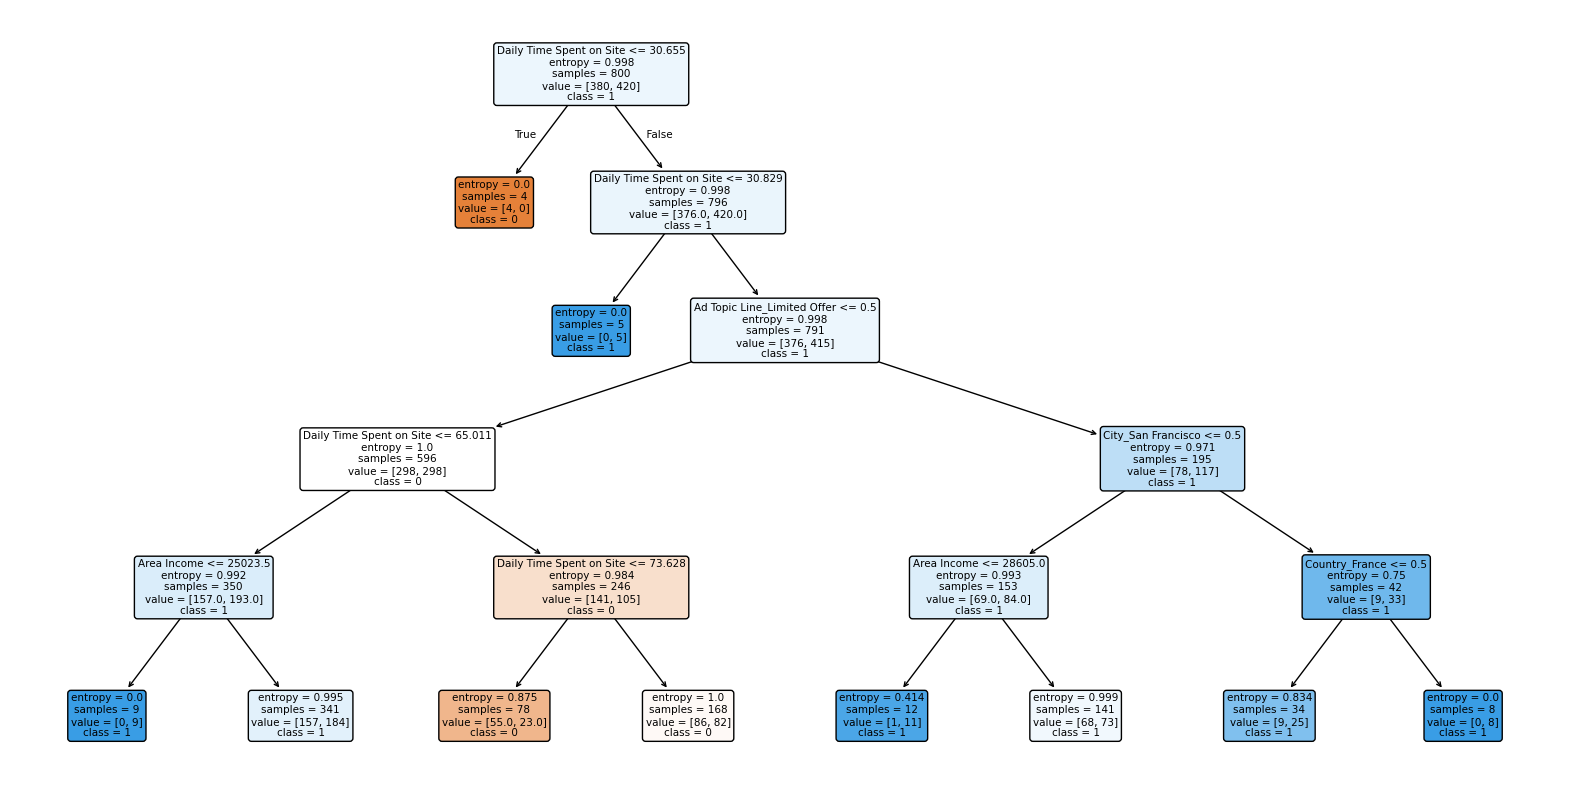

In [39]:
# Using Entropy

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(clf_entropy, filled=True, feature_names=X.columns, class_names=['0','1'], rounded=True)
plt.show()

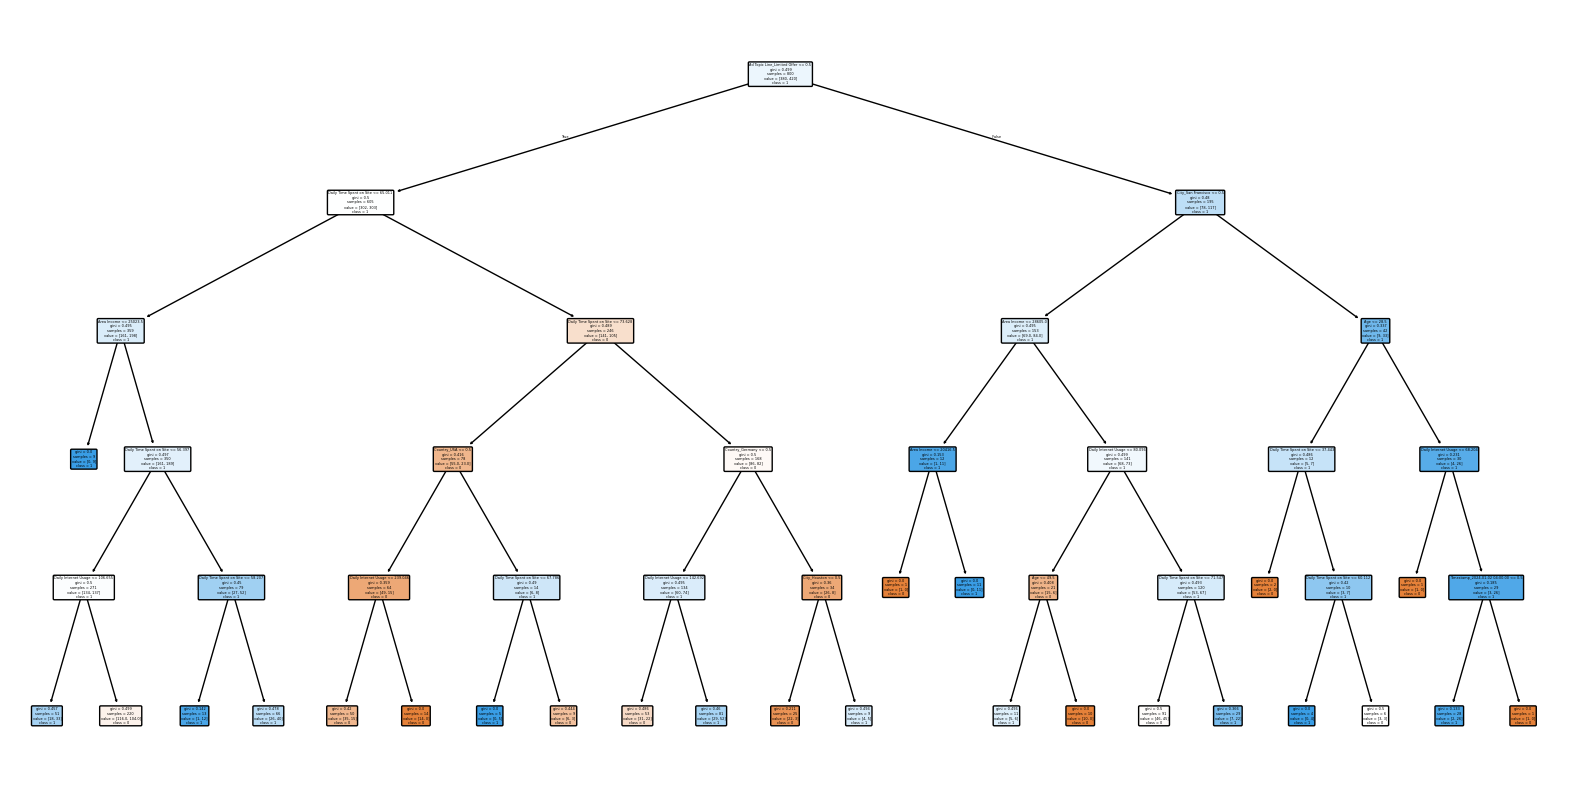

In [40]:
# Using Gini Index

import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plot_tree(clf_gini, filled=True, feature_names=X.columns, class_names=['0','1'], rounded=True)
plt.show()


TASKS:


1.   Implement decision tree algorithm on a dataset of your choice.
2.   Instead of Entropy, use GINI INDEX and observe the performance for any difference(s).
3.   Employ SciKit Learn implementation of decision tree and plot it. Observe for any difference(s).